# Deep Learning - FSL assignment

The goal of this assignment is training a prototypical neural network with the Omniglot dataset using episodic learning. Once trained, we will evaluate its accuracy on the test set.

We begin declaring the required libraries and setting the hyperparameters

In [26]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import Omniglot
import torchvision.transforms as transforms

# --------------------------
# Hyperparameters and settings
# --------------------------
k_way = 5     # number of classes per episode
n_support = 5     # number of support examples per class
n_query = 15      # number of query examples per class

episodes_per_epoch = 100 # number of episodes per epoch
num_epochs = 20  # number of epochs
learning_rate = 0.001 # initial lr
data_root = './data'  # directory to store/download Omniglot

# Number of test episodes for evaluation.
test_episodes = 600


The [Omniglot data set](https://github.com/brendenlake/omniglot) contains 50 alphabets. We split these into a background set of 30 alphabets and an evaluation set of 20 alphabets. Each of the 1623 characters was drawn online via Amazon's Mechanical Turk by 20 different people.

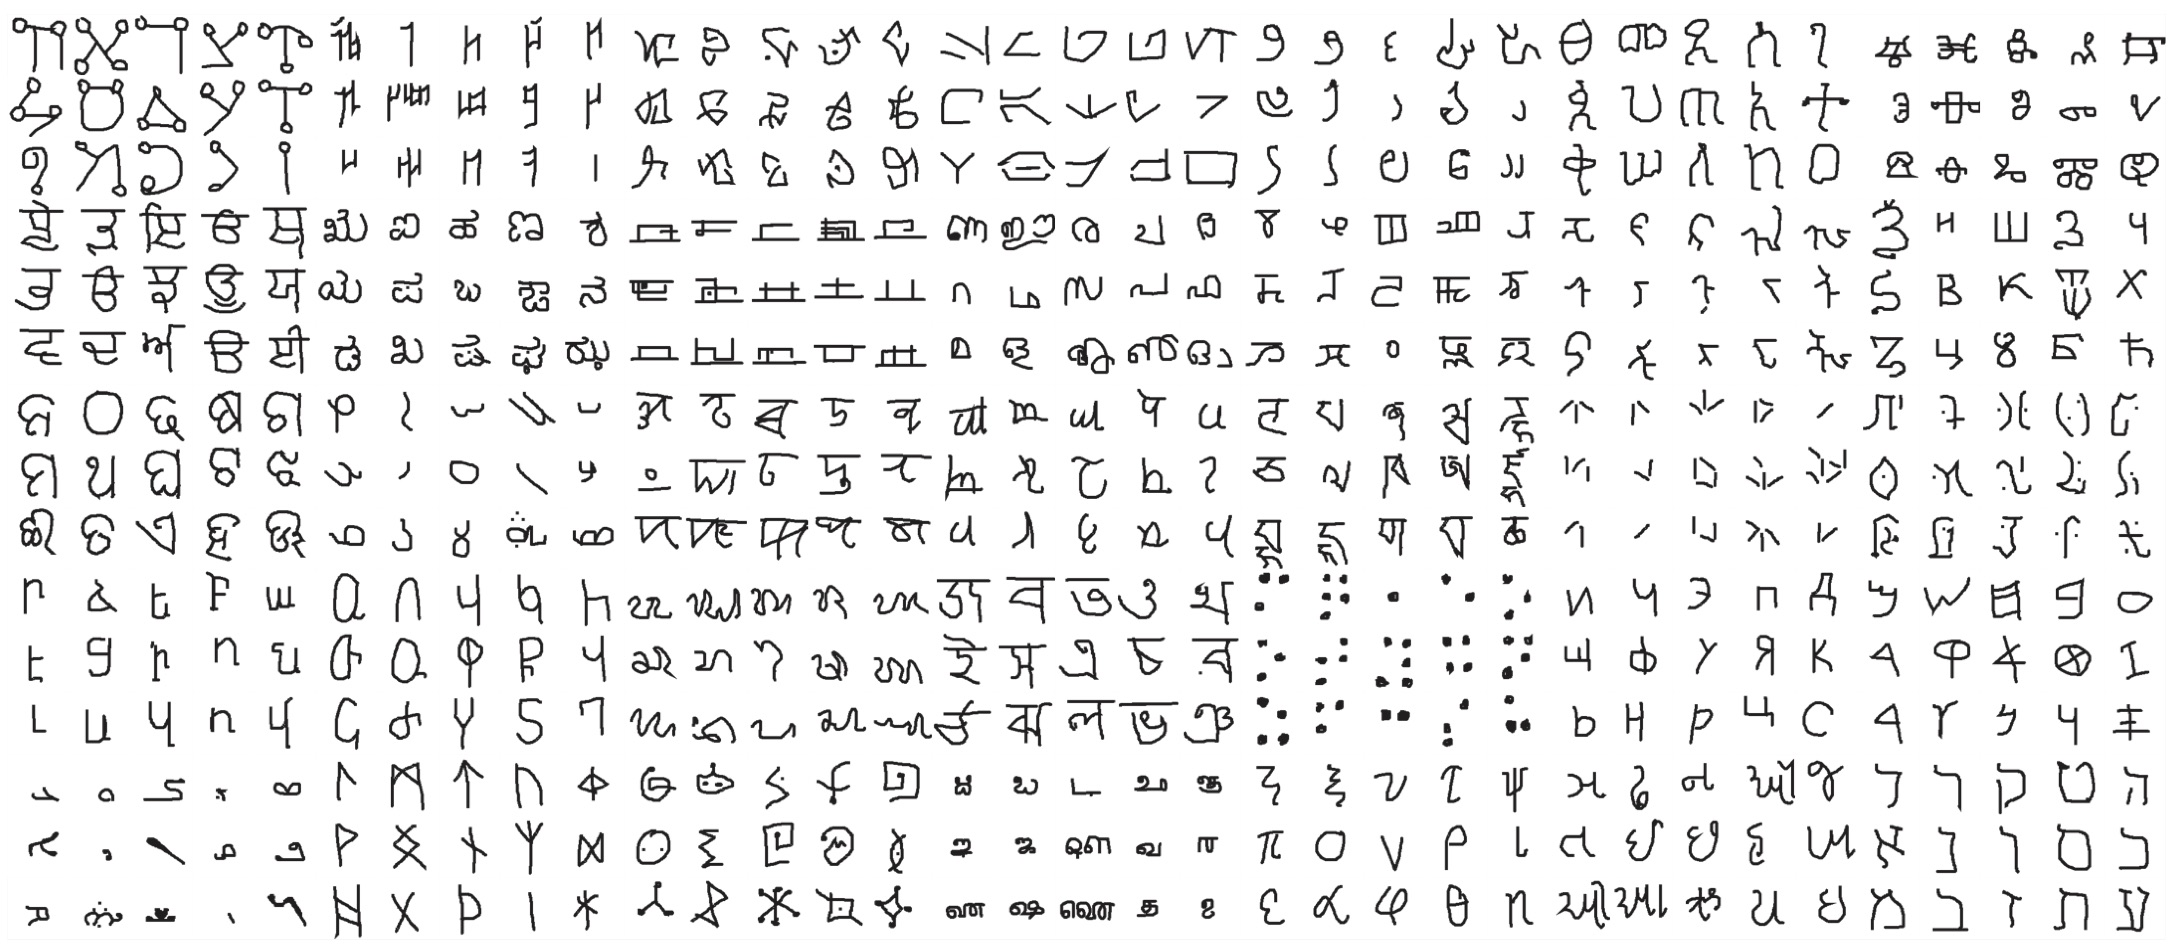

We prepare the data for episodic learning

In [27]:

# --------------------------
# Episodic Dataset for Omniglot
# --------------------------
class OmniglotEpisodicDataset(Dataset):
    """
    This dataset creates episodes for few-shot learning from the Omniglot dataset.
    Each episode randomly selects k_way classes and for each class samples
    n_support support examples and n_query query examples.
    """
    def __init__(self, root, transform, k_way, n_support, n_query, background=True):
        self.dataset = Omniglot(root=root, background=background, download=True, transform=transform)
        self.k_way = k_way
        self.n_support = n_support
        self.n_query = n_query

        # Build a dictionary mapping each class to the list of indices.
        self.classes = {}
        for idx, (_, label) in enumerate(self.dataset):
            if label not in self.classes:
                self.classes[label] = []
            self.classes[label].append(idx)
        self.keys = list(self.classes.keys())

    def __len__(self):
        # We generate episodes on the fly so return a large number.
        return 100000

    def __getitem__(self, index):
        # Randomly sample k_way classes.
        selected_classes = random.sample(self.keys, self.k_way)
        support_images = []
        support_labels = []
        query_images = []
        query_labels = []

        # For each selected class, sample support and query examples.
        for new_label, cls in enumerate(selected_classes):
            indices = self.classes[cls]
            # Sample without replacement a total of n_support + n_query images.
            selected_indices = random.sample(indices, self.n_support + self.n_query)
            support_idx = selected_indices[:self.n_support]
            query_idx = selected_indices[self.n_support:]
            for idx in support_idx:
                img, _ = self.dataset[idx]
                support_images.append(img)
                support_labels.append(new_label)
            for idx in query_idx:
                img, _ = self.dataset[idx]
                query_images.append(img)
                query_labels.append(new_label)

        # Stack images into tensors.
        support_images = torch.stack(support_images, dim=0)
        support_labels = torch.tensor(support_labels)
        query_images = torch.stack(query_images, dim=0)
        query_labels = torch.tensor(query_labels)
        return support_images, support_labels, query_images, query_labels


Model definition. A simple CNN with 4 blocks is used.

In [28]:
# --------------------------
# Prototypical Network Model
# --------------------------
class ProtoNet(nn.Module):
    """
    A simple convolutional encoder that maps images into an embedding space.
    Typically, a 4-block ConvNet is used for Omniglot.
    """
    def __init__(self, x_dim=1, hid_dim=64, z_dim=64):
        """
        x_dim: number of input channels (1 for grayscale)
        hid_dim: number of hidden channels
        z_dim: dimension of the final embedding
        """
        super(ProtoNet, self).__init__()
        self.encoder = nn.Sequential(
            # Block 1
            nn.Conv2d(x_dim, hid_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hid_dim),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # Block 2
            nn.Conv2d(hid_dim, hid_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hid_dim),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # Block 3
            nn.Conv2d(hid_dim, hid_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hid_dim),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # Block 4
            nn.Conv2d(hid_dim, z_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(z_dim),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        """
        Forward pass: input x shape: [batch, channels, height, width]
        Returns: embeddings of shape [batch, z_dim]
        """
        out = self.encoder(x)
        return out.view(out.size(0), -1)


Training function

In [29]:
# --------------------------
# Training Function for one Epoch
# --------------------------
def train(model, optimizer, dataloader, device):
    model.train()
    total_loss = 0.0

    # We iterate over episodes (each batch here is one episode)
    for batch_idx, (support_images, support_labels, query_images, query_labels) in enumerate(dataloader):
        support_images = support_images.squeeze(0).to(device)  # shape: [k_way*n_support, C, H, W]
        support_labels = support_labels.squeeze(0).to(device)
        query_images = query_images.squeeze(0).to(device)      # shape: [k_way*n_query, C, H, W]
        query_labels = query_labels.squeeze(0).to(device)

        optimizer.zero_grad()

        # Compute embeddings for support and query images.
        embeddings_support = model(support_images)  # shape: [k_way*n_support, z_dim]
        embeddings_query = model(query_images)

        # Compute prototypes.
        embedding_dim = embeddings_support.size(-1)
        embeddings_support = embeddings_support.view(k_way, n_support, embedding_dim)
        prototypes = embeddings_support.mean(dim=1)  # shape: [k_way, z_dim]

        # Compute distances and obtain predictions with softmax.
        distances = torch.cdist(embeddings_query, prototypes) ** 2  # [k_way*n_query, k_way]



        logits = -distances  # shape: [k_way*n_query, k_way]

        pred_labels = torch.argmax(logits, dim=1)


        loss = F.cross_entropy(logits, query_labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"Episode {batch_idx+1}/{episodes_per_epoch}, Loss: {loss.item():.4f}")

        if batch_idx + 1 >= episodes_per_epoch:
            break

    avg_loss = total_loss / episodes_per_epoch
    return avg_loss


Let's run training and check that it works properly.

In [30]:
# Set device: use GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations: resize to 28x28, convert to tensor and normalize.
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the episodic training dataset (using the background set).
train_dataset = OmniglotEpisodicDataset(
      root=data_root,
      transform=transform,
      k_way=k_way,
      n_support=n_support,
      n_query=n_query,
      background=True  # use the background set for training
)

# Since each __getitem__ returns one episode, set batch_size=1.
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Initialize the model and optimizer.
model = ProtoNet(x_dim=1, hid_dim=64, z_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop.
for epoch in range(1, num_epochs + 1):
    avg_loss = train(model, optimizer, train_loader, device)
    print(f"Epoch {epoch}/{num_epochs}, Average Loss: {avg_loss:.4f}")

# Save the model. We comment the following line so the notebook won't be too large for the submission
#torch.save(model.state_dict(), "protonet_omniglot.pth")
print("Training complete and model saved.")

Files already downloaded and verified
Episode 10/100, Loss: 0.0661
Episode 20/100, Loss: 0.0889
Episode 30/100, Loss: 0.7597
Episode 40/100, Loss: 0.3321
Episode 50/100, Loss: 0.2556
Episode 60/100, Loss: 0.0732
Episode 70/100, Loss: 0.1529
Episode 80/100, Loss: 0.0588
Episode 90/100, Loss: 0.1944
Episode 100/100, Loss: 0.0158
Epoch 1/20, Average Loss: 0.2394
Episode 10/100, Loss: 0.0848
Episode 20/100, Loss: 0.2206
Episode 30/100, Loss: 0.0010
Episode 40/100, Loss: 0.1341
Episode 50/100, Loss: 0.1553
Episode 60/100, Loss: 0.0568
Episode 70/100, Loss: 0.1419
Episode 80/100, Loss: 0.1435
Episode 90/100, Loss: 0.0223
Episode 100/100, Loss: 0.1355
Epoch 2/20, Average Loss: 0.0952
Episode 10/100, Loss: 0.1360
Episode 20/100, Loss: 0.2153
Episode 30/100, Loss: 0.0083
Episode 40/100, Loss: 0.0935
Episode 50/100, Loss: 0.0337
Episode 60/100, Loss: 0.0522
Episode 70/100, Loss: 0.0029
Episode 80/100, Loss: 0.0640
Episode 90/100, Loss: 0.0423
Episode 100/100, Loss: 0.1176
Epoch 3/20, Average Los

Once we have trained our model, we can evaluate it using the Omniglot test set. Since we only trained the embeddings, nearest neighbour is necessary to obtain the class.

In [31]:
# --------------------------
# Evaluation Function
# --------------------------
def evaluate(model, dataloader, device):
    """
    Evaluate the model over episodes and return the average query accuracy.
    """
    model.eval()
    total_acc = 0.0
    total_episodes = 0

    with torch.no_grad():
        for batch_idx, (support_images, support_labels, query_images, query_labels) in enumerate(dataloader):
            support_images = support_images.squeeze(0).to(device)  # shape: [k_way*n_support, C, H, W]
            support_labels = support_labels.squeeze(0).to(device)
            query_images = query_images.squeeze(0).to(device)      # shape: [k_way*n_query, C, H, W]
            query_labels = query_labels.squeeze(0).to(device)

            # Compute embeddings for support and query images.
            embeddings_support = model(support_images)  # shape: [k_way*n_support, z_dim]
            embeddings_query = model(query_images)      # shape: [k_way*n_query, z_dim]

            # Compute prototypes: reshape support embeddings to [k_way, n_support, z_dim] and take the mean.
            embedding_dim = embeddings_support.size(-1)
            embeddings_support = embeddings_support.view(k_way, n_support, embedding_dim)
            prototypes = embeddings_support.mean(dim=1)  # shape: [k_way, z_dim]

            # Compute squared Euclidean distances between each query embedding and each prototype.
            distances = torch.cdist(embeddings_query, prototypes) ** 2  # shape: [k_way*n_query, k_way]

            # Convert distances to logits by taking the negative distance.
            logits = -distances  # shape: [k_way*n_query, k_way]

            # For inference, obtain predictions using argmax over logits.
            pred_labels = torch.argmax(logits, dim=1)

            # Calculate accuracy for this episode.
            acc = (pred_labels == query_labels).float().mean().item()
            total_acc += acc
            total_episodes += 1

            if total_episodes >= test_episodes:
                break

    avg_acc = total_acc / total_episodes
    return avg_acc


Get the accuracy results on the Omniglot evaluation set

In [32]:
# Create episodic test dataset using the evaluation set (background=False).
test_dataset = OmniglotEpisodicDataset(
    root=data_root,
    transform=transform,
    k_way=k_way,
    n_support=n_support,
    n_query=n_query,
    background=False  # use the evaluation set for testing
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

test_acc = evaluate(model, test_loader, device)
print(f"\nTest Accuracy over {test_episodes} episodes: {test_acc*100:.2f}%")

Files already downloaded and verified

Test Accuracy over 600 episodes: 98.06%


Answer the following questions:
* For the given dataset, why do you think that episodic learning outperforms standard training (i.e., with all the training set)?

Episodic learning simulates the few-shot scenario during training, forcing the model to learn transferable representations and a robust similarity metric. This better prepares the model for classifying new, unseen classes with limited examples, compared to standard training on the full dataset.




* Make experiments changing the values K=3 and K=10 and write the conclusions.


For both k_way=3 and k_way=10, the test accuracies were nearly identical (98.31% vs. 97.79%). This similarity is likely due to episodic training, which forces the model to learn a robust and generalizable embedding space regardless of the number of classes per episode. Additionally, the Omniglot dataset—with its 50 alphabets (30 for background and 20 for evaluation) and 1623 characters drawn by 20 different people—provides a high level of diversity that helps stabilize performance across different k_way settings.



In [33]:
k_way = 3

In [34]:
# Set device: use GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations: resize to 28x28, convert to tensor and normalize.
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the episodic training dataset (using the background set).
train_dataset = OmniglotEpisodicDataset(
      root=data_root,
      transform=transform,
      k_way=k_way,
      n_support=n_support,
      n_query=n_query,
      background=True  # use the background set for training
)

# Since each __getitem__ returns one episode, set batch_size=1.
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Initialize the model and optimizer.
model = ProtoNet(x_dim=1, hid_dim=64, z_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop.
for epoch in range(1, num_epochs + 1):
    avg_loss = train(model, optimizer, train_loader, device)
    print(f"Epoch {epoch}/{num_epochs}, Average Loss: {avg_loss:.4f}")

# Save the model. We comment the following line so the notebook won't be too large for the submission
#torch.save(model.state_dict(), "protonet_omniglot.pth")
print("Training complete and model saved.")

Files already downloaded and verified
Episode 10/100, Loss: 0.0071
Episode 20/100, Loss: 0.2134
Episode 30/100, Loss: 0.3106
Episode 40/100, Loss: 0.0092
Episode 50/100, Loss: 0.0956
Episode 60/100, Loss: 0.3993
Episode 70/100, Loss: 0.0093
Episode 80/100, Loss: 0.0981
Episode 90/100, Loss: 0.1377
Episode 100/100, Loss: 0.1046
Epoch 1/20, Average Loss: 0.2478
Episode 10/100, Loss: 1.3174
Episode 20/100, Loss: 0.0283
Episode 30/100, Loss: 0.1321
Episode 40/100, Loss: 0.0261
Episode 50/100, Loss: 0.2756
Episode 60/100, Loss: 0.0369
Episode 70/100, Loss: 0.0044
Episode 80/100, Loss: 0.0455
Episode 90/100, Loss: 0.1318
Episode 100/100, Loss: 0.2584
Epoch 2/20, Average Loss: 0.0973
Episode 10/100, Loss: 0.0886
Episode 20/100, Loss: 0.0012
Episode 30/100, Loss: 0.0479
Episode 40/100, Loss: 0.0023
Episode 50/100, Loss: 0.0011
Episode 60/100, Loss: 0.1071
Episode 70/100, Loss: 0.0007
Episode 80/100, Loss: 0.0001
Episode 90/100, Loss: 0.0182
Episode 100/100, Loss: 0.0002
Epoch 3/20, Average Los

In [35]:
# Create episodic test dataset using the evaluation set (background=False).
test_dataset = OmniglotEpisodicDataset(
    root=data_root,
    transform=transform,
    k_way=k_way,
    n_support=n_support,
    n_query=n_query,
    background=False  # use the evaluation set for testing
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

test_acc = evaluate(model, test_loader, device)
print(f"\nTest Accuracy over {test_episodes} episodes: {test_acc*100:.2f}%")

Files already downloaded and verified

Test Accuracy over 600 episodes: 98.21%


In [40]:
k_way = 10

In [41]:
# Set device: use GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations: resize to 28x28, convert to tensor and normalize.
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the episodic training dataset (using the background set).
train_dataset = OmniglotEpisodicDataset(
      root=data_root,
      transform=transform,
      k_way=k_way,
      n_support=n_support,
      n_query=n_query,
      background=True  # use the background set for training
)

# Since each __getitem__ returns one episode, set batch_size=1.
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Initialize the model and optimizer.
model = ProtoNet(x_dim=1, hid_dim=64, z_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop.
for epoch in range(1, num_epochs + 1):
    avg_loss = train(model, optimizer, train_loader, device)
    print(f"Epoch {epoch}/{num_epochs}, Average Loss: {avg_loss:.4f}")

# Save the model. We comment the following line so the notebook won't be too large for the submission
#torch.save(model.state_dict(), "protonet_omniglot.pth")
print("Training complete and model saved.")

Files already downloaded and verified
Episode 10/100, Loss: 0.4476
Episode 20/100, Loss: 0.8768
Episode 30/100, Loss: 0.6976
Episode 40/100, Loss: 0.3073
Episode 50/100, Loss: 0.2214
Episode 60/100, Loss: 0.0332
Episode 70/100, Loss: 0.1201
Episode 80/100, Loss: 0.0661
Episode 90/100, Loss: 0.0660
Episode 100/100, Loss: 0.1643
Epoch 1/20, Average Loss: 0.2851
Episode 10/100, Loss: 0.0492
Episode 20/100, Loss: 0.0581
Episode 30/100, Loss: 0.0684
Episode 40/100, Loss: 0.0451
Episode 50/100, Loss: 0.0363
Episode 60/100, Loss: 0.2211
Episode 70/100, Loss: 0.2358
Episode 80/100, Loss: 0.0877
Episode 90/100, Loss: 0.0904
Episode 100/100, Loss: 0.1199
Epoch 2/20, Average Loss: 0.1041
Episode 10/100, Loss: 0.0167
Episode 20/100, Loss: 0.0495
Episode 30/100, Loss: 0.1922
Episode 40/100, Loss: 0.2658
Episode 50/100, Loss: 0.0376
Episode 60/100, Loss: 0.0693
Episode 70/100, Loss: 0.0870
Episode 80/100, Loss: 0.1614
Episode 90/100, Loss: 0.0255
Episode 100/100, Loss: 0.0602
Epoch 3/20, Average Los

In [42]:
# Create episodic test dataset using the evaluation set (background=False).
test_dataset = OmniglotEpisodicDataset(
    root=data_root,
    transform=transform,
    k_way=k_way,
    n_support=n_support,
    n_query=n_query,
    background=False  # use the evaluation set for testing
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

test_acc = evaluate(model, test_loader, device)
print(f"\nTest Accuracy over {test_episodes} episodes: {test_acc*100:.2f}%")

Files already downloaded and verified

Test Accuracy over 600 episodes: 97.63%
